In [3]:
import numpy as np 
import torch 
from torch.utils.data import TensorDataset,Dataset,DataLoader,random_split
import pandas as pd
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [4]:
#----------------------Load the Excel file, getting the dataframe and index_tensor-----------------------
def load_data(file_path, sheet_name):
    sheet_name = sheet_name
    df = pd.read_excel(file_path, sheet_name=sheet_name)
    index_tensor = (df['A_position_counted_from_5_end_of_gRNA'] + 20).astype(int) 
    return df, index_tensor

In [5]:
def pearson_correlation(predicted, actual):
    pred_mean = predicted.mean()
    actual_mean = actual.mean()
    covariance = ((predicted - pred_mean) * (actual - actual_mean)).sum()
    pred_std = ((predicted - pred_mean) ** 2).sum().sqrt()
    actual_std = ((actual - actual_mean) ** 2).sum().sqrt()
    return (covariance / (pred_std * actual_std)).item()

In [5]:
# check if the function load_data() works, remember to change the file path to your own.
print(load_data(file_path='D:/01IscBML/train.xlsx',sheet_name="Train")[1])

0        21
1        23
2        24
3        25
4        27
         ..
27871    27
27872    32
27873    36
27874    27
27875    31
Name: A_position_counted_from_5_end_of_gRNA, Length: 27876, dtype: int32


In [6]:
# Here I define a class BCEFocalLoss to address the inbalance problem of the dataset. It's a loss function. 
# But for the final model, I didn't use this loss function. I just use the MSEloss.

class BCEFocalLoss(torch.nn.Module):
    def __init__(self, gamma=2, alpha=0.6, reduction='mean'):
        super().__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction
        self.hardtanh = nn.Hardtanh(min_val=0, max_val=1, inplace=False)
        self.episilon = 1e-8
    def forward(self, _input, target):
        pt = _input
        # pt = torch.clamp(_input,0,1)
        alpha = self.alpha
        episilon = self.episilon
        loss = - alpha * (1 - pt) ** self.gamma * target * torch.log(pt + episilon) - \
               (1 - alpha) * pt ** self.gamma * (1 - target) * torch.log(1 - pt + episilon)
        if self.reduction == 'mean':
            loss = torch.mean(loss)
        elif self.reduction == 'sum':
            loss = torch.sum(loss)
        return loss

In [7]:
import pandas as pd
import torch

class FeatureProcessor:
    def __init__(self, file_path='D:/01IscBML/', file_name=''):
        self.category_map = {'A': 0, 'T': 1, 'C': 2, 'G': 3}
        self.data_path = file_path + file_name
        self.df, self.index_tensor = self.load_data(self.data_path)  # load the df and index tensor
        self.combined_features, self.tam_onehot, self.sequence_length = self.feature_processing()
        self.labels_tensor = self.label()

    def __len__(self):
        return len(self.df.shape[0])

    def load_data(self, data_path):
        df = pd.read_excel(data_path)
        index_tensor = (df['A_position_counted_from_5_end_of_gRNA'] + 20).astype(int) - 1  # Warning: 0-indexed
        return df, index_tensor

    def sequence_to_one_hot(self, sequence, categories="ATCG"):
        category_map = {char: idx for idx, char in enumerate(categories)}
        one_hot = []
        for char in sequence:
            one_hot_char = [0] * len(categories)
            if char in category_map:
                one_hot_char[category_map[char]] = 1
            one_hot.append(one_hot_char)
        return one_hot

    def feature_processing(self):
        sequence_data = self.df['Target_site_sequence']
        sequence_length = len(sequence_data.iloc[0])
        one_hot_features = sequence_data.apply(self.sequence_to_one_hot)

        features_tensor = torch.tensor(list(one_hot_features), dtype=torch.float32)

        index_one_hot_features = []
        for idx in self.index_tensor:
            index_one_hot = [0] * sequence_length
            if 0 <= idx < sequence_length:
                index_one_hot[idx] = 1
            index_one_hot_features.append(index_one_hot)

        TAM_one_hot_features = []
        for idx in self.index_tensor:
            TAM_one_hot = [0] * sequence_length
            # Ensure valid positions for TAM features within sequence_length
            valid_extra_idxs = [i for i in range(36, 40) if 0 <= i < sequence_length]
            for extra_idx in valid_extra_idxs:
                TAM_one_hot[extra_idx] = 2 if extra_idx in range(36, 38) else 3
            TAM_one_hot_features.append(TAM_one_hot)

        index_one_hot_tensor = torch.tensor(index_one_hot_features, dtype=torch.float32).unsqueeze(2)
        TAM_one_hot_features = torch.tensor(TAM_one_hot_features, dtype=torch.float32).unsqueeze(2)

        combined_features = torch.cat((features_tensor, index_one_hot_tensor,TAM_one_hot_features), dim=2)
        # combined_features = torch.cat((features_tensor, index_one_hot_tensor), dim=2)
        return combined_features, TAM_one_hot_features, sequence_length
    
    def label(self):
        #---------------------Prepare labels tensor-----------------------
        labels_tensor = torch.tensor(self.df['a-to-g(%)'].values/100, dtype=torch.float32).unsqueeze(1)  # Add a dimension for labels
        return labels_tensor

In [8]:
import torch
import torch.nn as nn

class TAMEnhancer(nn.Module):
    def __init__(self, one_hot_dim, embedding_dim, feature_dim):
        super(TAMEnhancer, self).__init__()
        self.embedding = nn.Embedding(num_embeddings=one_hot_dim, embedding_dim=embedding_dim)
        self.linear = nn.Linear(embedding_dim, feature_dim) # lower dimensionality
        self.relu = nn.ReLU()

    def forward(self, tam_indices):
        """
        tam_indices: input shape (batch_size, sequence_length, feature_dim)
        """
        # embedding for the TAM features
        batch_size, sequence_length, feature_dim = tam_indices.shape  # batch_size = 64, sequence_length = 4, feature_dim = 6
        # print("sequence_length:", sequence_length, "feature_dim:", feature_dim) # sequence_length: 4 feature_dim: 6
        tam_indices_flat = tam_indices.view(-1, feature_dim)  #flatten the formal two dimension ，shape:(batch_size * sequence_length, feature_dim)

        # embedding
        tam_embedded = self.embedding(tam_indices_flat.long())  # 形状为 (batch_size * sequence_length, feature_dim, embedding_dim)
        tam_embedded = tam_embedded.mean(dim=-2)  # aggregate the embeddings of the same position

        # lower dimensionality
        tam_features = self.linear(tam_embedded)  # 形状为 (batch_size * sequence_length, feature_dim)
        tam_features = self.relu(tam_features)#[256,6]

        tam_features = tam_features.view(batch_size, feature_dim,-1)  # (batch_size, sequence_length, feature_dim) = (64, 4, 4)
        tam_features = tam_features.permute(0, 2, 1)
        # print("tam_features.shape:", tam_features.shape) 

        return tam_features


In [9]:
class LocalCNN(nn.Module):
    def __init__(self, sequence_length, tam_one_hot_dim=4, tam_embedding_dim=4, kernel_size=21):
        super(LocalCNN, self).__init__()

        # TAMEnhancer
        self.tam_enhancer = TAMEnhancer(one_hot_dim=tam_one_hot_dim, embedding_dim=tam_embedding_dim, feature_dim=6)
        
        # Convolutional layers
        self.conv1 = nn.Conv1d(in_channels=6 , out_channels=32, kernel_size=kernel_size, padding=kernel_size // 2)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=kernel_size, padding=kernel_size // 2)
        self.conv3 = nn.Conv1d(in_channels=64, out_channels=64, kernel_size=kernel_size, padding=kernel_size // 2)
        self.conv4 = nn.Conv1d(in_channels=64, out_channels=64, kernel_size=kernel_size, padding=kernel_size // 2)
        
        # Batch Normalization
        self.bn1 = nn.BatchNorm1d(32)
        self.bn2 = nn.BatchNorm1d(64)
        self.bn3 = nn.BatchNorm1d(64)
        self.bn4 = nn.BatchNorm1d(64)   
        
        # Activation functions
        self.leaky_relu = nn.LeakyReLU(0.1)
        self.hardtanh = nn.Hardtanh(min_val=0, max_val=1)
        self.dropout = nn.Dropout(0.5)
        
        # Global pooling
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        
        # Fully connected layers
        self.fc1 = nn.Linear(64, 256)
        self.fc2 = nn.Linear(256, 32)
        self.fc3 = nn.Linear(32, 1)

    def forward(self, x, tam_indices):
        # Enhance TAM features


        tam_features = self.tam_enhancer(tam_indices)  # (batch_size, sequence_length, embedding_dim)
        # print(tam_features.shape)
        # print(x.shape)
        # Concatenate TAM features with the input sequence
        x = torch.cat((x, tam_features), dim=1)  # (batch_size, sequence_length, 6 + tam_embedding_dim)

        # Input permutation for Conv1d
        x = x.permute(0, 2, 1)  # (batch_size, 12 + tam_embedding_dim, sequence_length)
        
        # Convolutional block 1
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.leaky_relu(x)
        
        # Convolutional block 2
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.leaky_relu(x)
        
        # Convolutional block 3
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.leaky_relu(x)

                
        # Convolutional block 4
        x = self.conv4(x)
        x = self.bn4(x)
        x = self.leaky_relu(x)
        
        # Global average pooling
        x = self.global_pool(x).squeeze(-1)
        
        # Fully connected layers
        x = self.fc1(x)
        x = self.leaky_relu(x)
        x = self.dropout(x)
        
        x = self.fc2(x)
        x = self.leaky_relu(x)
        
        x = self.fc3(x)
        x = self.hardtanh(x)

        return x


In [21]:
train_label_data = FeatureProcessor(file_path='D:/01IscBML/', file_name='A_to_G_S18_Train_del1700_90%.xlsx').labels_tensor
train_combined_features = FeatureProcessor(file_path='D:/01IscBML/', file_name='A_to_G_S18_Train_del1700_90%.xlsx').combined_features
train_Tam_features = train_combined_features[:,36:40,:].long()


val_label_data = FeatureProcessor(file_path='D:/01IscBML/', file_name='A_to_G_S18_Val_del1700_10%.xlsx').labels_tensor
val_combined_features = FeatureProcessor(file_path='D:/01IscBML/', file_name='A_to_G_S18_Val_del1700_10%.xlsx').combined_features
val_Tam_features = val_combined_features[:,36:40,:].long()

#---------------total dataset--------------
# label_data = FeatureProcessor(file_path='D:/01IscBML/', file_name='A_to_G_S19_del.xlsx').labels_tensor
# combined_features = FeatureProcessor(file_path='D:/01IscBML/', file_name='A_to_G_S19_del.xlsx').combined_features
# Tam_features = combined_features[:,36:40,:].long()

# print(f"combined_features shape: {combined_features.shape}")
# print(f"Tam_features shape: {Tam_features.shape}")
# print(f"label_data shape: {label_data.shape}")

#---------------------Create dataset and dataloader-----------------
train_dataset = TensorDataset(train_combined_features,train_Tam_features, train_label_data)
val_dataset = TensorDataset(val_combined_features,val_Tam_features, val_label_data)

# Turn shuffle to False if you want to keep the predefined order of the data
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False)  # You can adjust the batch size as needed
val_dataloader = DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False)  # You can adjust the batch size as needed

#----------------------Example to check batches---------------------
# for i, (batch_features,batch_Tam_features, batch_labels) in enumerate(dataloader):
#     print("Batch", i)
#     # print(batch_features.requires_grad)
#     # print("Features Batch Shape:", batch_features[:,36:40,:])  # (batch_size, sequence_length, channel_size)
#     print("Tam_features Batch Shape:", batch_Tam_features.shape)  # (batch_size, sequence_length, channel_size)
#     print("Labels Batch Shape:", batch_labels[20])  # (batch_size, 1)
#     i+=1
#     if i == 2:
#         break

#------------------pred dataset---------------------
test_label_data = FeatureProcessor(file_path='D:/01IscBML/',file_name='./test_del_keep1700.xlsx').labels_tensor
test_combined_features = FeatureProcessor(file_path='D:/01IscBML/',file_name='./test_del_keep1700.xlsx').combined_features
test_Tam_features = test_combined_features[:,36:40,:].long()
#---------------------Create dataset and dataloader-----------------
test_dataset = TensorDataset(test_combined_features, test_Tam_features, test_label_data)
testset_length = len(test_dataset)
print(testset_length)

# Turn shuffle to False if you want to keep the predefined order of the data
test_dataloader = DataLoader(test_dataset, batch_size=testset_length, shuffle=False, drop_last=True)

2864


In [11]:
# #------------------split train&validation dataset---------------------
# from torch.utils.data import random_split, DataLoader

# dataset_size = len(dataset)
# train_size = int(0.8 * dataset_size) 

# val_size = dataset_size - train_size  
# print(val_size)

# train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, drop_last=True)
# val_dataloader = DataLoader(val_dataset, batch_size=val_size, shuffle=False, drop_last=True)    

# for i, train_data in enumerate(train_dataloader):
#     print("Batch", i)
#     channel = train_data[0].shape[2]
#     print("Features Batch Shape:", train_data[0].shape)  # (batch_size, sequence_length, channel_size)
#     print("Labels Batch Shape:", train_data[1].shape)  # (batch_size, 1)
#     print("Channel Size:", channel)
#     i+=1
#     if i == 2:
#         break

Epoch 1/150: 100%|██████████| 323/323 [00:01<00:00, 173.23it/s]


Model saved with Pearson correlation: 0.6378
Epoch [1/150]
Training Loss: 0.0461
Validation Pearson Correlation: 0.6378


Epoch 2/150: 100%|██████████| 323/323 [00:01<00:00, 219.58it/s]


Model saved with Pearson correlation: 0.6589
Epoch [2/150]
Training Loss: 0.0341
Validation Pearson Correlation: 0.6589


Epoch 3/150: 100%|██████████| 323/323 [00:01<00:00, 235.36it/s]


Model saved with Pearson correlation: 0.6788
Epoch [3/150]
Training Loss: 0.0294
Validation Pearson Correlation: 0.6788


Epoch 4/150: 100%|██████████| 323/323 [00:01<00:00, 215.37it/s]


Model saved with Pearson correlation: 0.7102
Epoch [4/150]
Training Loss: 0.0260
Validation Pearson Correlation: 0.7102


Epoch 5/150: 100%|██████████| 323/323 [00:01<00:00, 235.28it/s]


Model saved with Pearson correlation: 0.7556
Epoch [5/150]
Training Loss: 0.0228
Validation Pearson Correlation: 0.7556


Epoch 6/150: 100%|██████████| 323/323 [00:01<00:00, 243.79it/s]


Model saved with Pearson correlation: 0.7582
Epoch [6/150]
Training Loss: 0.0198
Validation Pearson Correlation: 0.7582


Epoch 7/150: 100%|██████████| 323/323 [00:01<00:00, 247.39it/s]


Model saved with Pearson correlation: 0.7584
Epoch [7/150]
Training Loss: 0.0168
Validation Pearson Correlation: 0.7584


Epoch 8/150: 100%|██████████| 323/323 [00:01<00:00, 243.67it/s]


Model saved with Pearson correlation: 0.7584
Epoch [8/150]
Training Loss: 0.0142
Validation Pearson Correlation: 0.7309


Epoch 9/150: 100%|██████████| 323/323 [00:01<00:00, 269.35it/s]


Model saved with Pearson correlation: 0.7776
Epoch [9/150]
Training Loss: 0.0120
Validation Pearson Correlation: 0.7776


Epoch 10/150: 100%|██████████| 323/323 [00:01<00:00, 259.37it/s]


Model saved with Pearson correlation: 0.7975
Epoch [10/150]
Training Loss: 0.0104
Validation Pearson Correlation: 0.7975


Epoch 11/150: 100%|██████████| 323/323 [00:01<00:00, 263.60it/s]


Model saved with Pearson correlation: 0.7975
Epoch [11/150]
Training Loss: 0.0199
Validation Pearson Correlation: 0.7382


Epoch 12/150: 100%|██████████| 323/323 [00:01<00:00, 269.24it/s]


Model saved with Pearson correlation: 0.7975
Epoch [12/150]
Training Loss: 0.0180
Validation Pearson Correlation: 0.7368


Epoch 13/150: 100%|██████████| 323/323 [00:01<00:00, 267.82it/s]


Model saved with Pearson correlation: 0.7975
Epoch [13/150]
Training Loss: 0.0172
Validation Pearson Correlation: 0.7628


Epoch 14/150: 100%|██████████| 323/323 [00:01<00:00, 259.85it/s]


Model saved with Pearson correlation: 0.7975
Epoch [14/150]
Training Loss: 0.0159
Validation Pearson Correlation: 0.7550


Epoch 15/150: 100%|██████████| 323/323 [00:01<00:00, 260.49it/s]


Model saved with Pearson correlation: 0.7975
Epoch [15/150]
Training Loss: 0.0144
Validation Pearson Correlation: 0.7510


Epoch 16/150: 100%|██████████| 323/323 [00:01<00:00, 273.07it/s]


Model saved with Pearson correlation: 0.7975
Epoch [16/150]
Training Loss: 0.0137
Validation Pearson Correlation: 0.7550


Epoch 17/150: 100%|██████████| 323/323 [00:01<00:00, 268.12it/s]


Model saved with Pearson correlation: 0.7975
Epoch [17/150]
Training Loss: 0.0127
Validation Pearson Correlation: 0.7596


Epoch 18/150: 100%|██████████| 323/323 [00:01<00:00, 257.23it/s]


Model saved with Pearson correlation: 0.7975
Epoch [18/150]
Training Loss: 0.0120
Validation Pearson Correlation: 0.7505


Epoch 19/150: 100%|██████████| 323/323 [00:01<00:00, 267.09it/s]


Model saved with Pearson correlation: 0.7975
Epoch [19/150]
Training Loss: 0.0108
Validation Pearson Correlation: 0.7697


Epoch 20/150: 100%|██████████| 323/323 [00:01<00:00, 260.96it/s]


Model saved with Pearson correlation: 0.7975
Epoch [20/150]
Training Loss: 0.0098
Validation Pearson Correlation: 0.7679


Epoch 21/150: 100%|██████████| 323/323 [00:01<00:00, 258.52it/s]


Model saved with Pearson correlation: 0.7975
Epoch [21/150]
Training Loss: 0.0090
Validation Pearson Correlation: 0.7785


Epoch 22/150: 100%|██████████| 323/323 [00:01<00:00, 264.68it/s]


Model saved with Pearson correlation: 0.7975
Epoch [22/150]
Training Loss: 0.0083
Validation Pearson Correlation: 0.7759


Epoch 23/150: 100%|██████████| 323/323 [00:01<00:00, 257.01it/s]


Model saved with Pearson correlation: 0.7975
Epoch [23/150]
Training Loss: 0.0076
Validation Pearson Correlation: 0.7658


Epoch 24/150: 100%|██████████| 323/323 [00:01<00:00, 261.78it/s]


Model saved with Pearson correlation: 0.7975
Epoch [24/150]
Training Loss: 0.0068
Validation Pearson Correlation: 0.7663


Epoch 25/150: 100%|██████████| 323/323 [00:01<00:00, 258.47it/s]


Model saved with Pearson correlation: 0.7975
Epoch [25/150]
Training Loss: 0.0062
Validation Pearson Correlation: 0.7731


Epoch 26/150: 100%|██████████| 323/323 [00:01<00:00, 258.42it/s]


Model saved with Pearson correlation: 0.7975
Epoch [26/150]
Training Loss: 0.0056
Validation Pearson Correlation: 0.7934


Epoch 27/150: 100%|██████████| 323/323 [00:01<00:00, 251.34it/s]


Model saved with Pearson correlation: 0.8015
Epoch [27/150]
Training Loss: 0.0051
Validation Pearson Correlation: 0.8015


Epoch 28/150: 100%|██████████| 323/323 [00:01<00:00, 237.33it/s]


Model saved with Pearson correlation: 0.8049
Epoch [28/150]
Training Loss: 0.0047
Validation Pearson Correlation: 0.8049


Epoch 29/150: 100%|██████████| 323/323 [00:01<00:00, 256.19it/s]


Model saved with Pearson correlation: 0.8079
Epoch [29/150]
Training Loss: 0.0044
Validation Pearson Correlation: 0.8079


Epoch 30/150: 100%|██████████| 323/323 [00:01<00:00, 252.50it/s]


Model saved with Pearson correlation: 0.8101
Epoch [30/150]
Training Loss: 0.0042
Validation Pearson Correlation: 0.8101


Epoch 31/150: 100%|██████████| 323/323 [00:01<00:00, 254.82it/s]


Model saved with Pearson correlation: 0.8101
Epoch [31/150]
Training Loss: 0.0153
Validation Pearson Correlation: 0.6722


Epoch 32/150: 100%|██████████| 323/323 [00:01<00:00, 256.58it/s]


Model saved with Pearson correlation: 0.8101
Epoch [32/150]
Training Loss: 0.0135
Validation Pearson Correlation: 0.7463


Epoch 33/150: 100%|██████████| 323/323 [00:01<00:00, 259.77it/s]


Model saved with Pearson correlation: 0.8101
Epoch [33/150]
Training Loss: 0.0122
Validation Pearson Correlation: 0.7707


Epoch 34/150: 100%|██████████| 323/323 [00:01<00:00, 257.83it/s]


Model saved with Pearson correlation: 0.8101
Epoch [34/150]
Training Loss: 0.0109
Validation Pearson Correlation: 0.7653


Epoch 35/150: 100%|██████████| 323/323 [00:01<00:00, 262.21it/s]


Model saved with Pearson correlation: 0.8101
Epoch [35/150]
Training Loss: 0.0104
Validation Pearson Correlation: 0.7254


Epoch 36/150: 100%|██████████| 323/323 [00:01<00:00, 258.79it/s]


Model saved with Pearson correlation: 0.8101
Epoch [36/150]
Training Loss: 0.0104
Validation Pearson Correlation: 0.7217


Epoch 37/150: 100%|██████████| 323/323 [00:01<00:00, 254.18it/s]


Model saved with Pearson correlation: 0.8101
Epoch [37/150]
Training Loss: 0.0092
Validation Pearson Correlation: 0.7723


Epoch 38/150: 100%|██████████| 323/323 [00:01<00:00, 260.97it/s]


Model saved with Pearson correlation: 0.8101
Epoch [38/150]
Training Loss: 0.0092
Validation Pearson Correlation: 0.7958


Epoch 39/150: 100%|██████████| 323/323 [00:01<00:00, 253.60it/s]


Model saved with Pearson correlation: 0.8101
Epoch [39/150]
Training Loss: 0.0089
Validation Pearson Correlation: 0.7490


Epoch 40/150: 100%|██████████| 323/323 [00:01<00:00, 255.52it/s]


Model saved with Pearson correlation: 0.8101
Epoch [40/150]
Training Loss: 0.0086
Validation Pearson Correlation: 0.7808


Epoch 41/150: 100%|██████████| 323/323 [00:01<00:00, 250.27it/s]


Model saved with Pearson correlation: 0.8101
Epoch [41/150]
Training Loss: 0.0078
Validation Pearson Correlation: 0.7662


Epoch 42/150: 100%|██████████| 323/323 [00:01<00:00, 244.97it/s]


Model saved with Pearson correlation: 0.8101
Epoch [42/150]
Training Loss: 0.0075
Validation Pearson Correlation: 0.7753


Epoch 43/150: 100%|██████████| 323/323 [00:01<00:00, 241.31it/s]


Model saved with Pearson correlation: 0.8101
Epoch [43/150]
Training Loss: 0.0075
Validation Pearson Correlation: 0.7871


Epoch 44/150: 100%|██████████| 323/323 [00:01<00:00, 257.81it/s]


Model saved with Pearson correlation: 0.8101
Epoch [44/150]
Training Loss: 0.0070
Validation Pearson Correlation: 0.7940


Epoch 45/150: 100%|██████████| 323/323 [00:01<00:00, 259.66it/s]


Model saved with Pearson correlation: 0.8101
Epoch [45/150]
Training Loss: 0.0067
Validation Pearson Correlation: 0.7600


Epoch 46/150: 100%|██████████| 323/323 [00:01<00:00, 244.72it/s]


Model saved with Pearson correlation: 0.8101
Epoch [46/150]
Training Loss: 0.0061
Validation Pearson Correlation: 0.7977


Epoch 47/150: 100%|██████████| 323/323 [00:01<00:00, 255.44it/s]


Model saved with Pearson correlation: 0.8101
Epoch [47/150]
Training Loss: 0.0057
Validation Pearson Correlation: 0.7781


Epoch 48/150: 100%|██████████| 323/323 [00:01<00:00, 262.50it/s]


Model saved with Pearson correlation: 0.8101
Epoch [48/150]
Training Loss: 0.0056
Validation Pearson Correlation: 0.7959


Epoch 49/150: 100%|██████████| 323/323 [00:01<00:00, 259.67it/s]


Model saved with Pearson correlation: 0.8101
Epoch [49/150]
Training Loss: 0.0053
Validation Pearson Correlation: 0.8043


Epoch 50/150: 100%|██████████| 323/323 [00:01<00:00, 264.08it/s]


Model saved with Pearson correlation: 0.8101
Epoch [50/150]
Training Loss: 0.0050
Validation Pearson Correlation: 0.7808


Epoch 51/150: 100%|██████████| 323/323 [00:01<00:00, 257.71it/s]


Model saved with Pearson correlation: 0.8101
Epoch [51/150]
Training Loss: 0.0046
Validation Pearson Correlation: 0.7899


Epoch 52/150: 100%|██████████| 323/323 [00:01<00:00, 258.07it/s]


Model saved with Pearson correlation: 0.8101
Epoch [52/150]
Training Loss: 0.0043
Validation Pearson Correlation: 0.7904


Epoch 53/150: 100%|██████████| 323/323 [00:01<00:00, 260.98it/s]


Model saved with Pearson correlation: 0.8101
Epoch [53/150]
Training Loss: 0.0043
Validation Pearson Correlation: 0.7724


Epoch 54/150: 100%|██████████| 323/323 [00:01<00:00, 257.13it/s]


Model saved with Pearson correlation: 0.8101
Epoch [54/150]
Training Loss: 0.0041
Validation Pearson Correlation: 0.7629


Epoch 55/150: 100%|██████████| 323/323 [00:01<00:00, 262.21it/s]


Model saved with Pearson correlation: 0.8101
Epoch [55/150]
Training Loss: 0.0036
Validation Pearson Correlation: 0.7916


Epoch 56/150: 100%|██████████| 323/323 [00:01<00:00, 261.13it/s]


Model saved with Pearson correlation: 0.8103
Epoch [56/150]
Training Loss: 0.0035
Validation Pearson Correlation: 0.8103


Epoch 57/150: 100%|██████████| 323/323 [00:01<00:00, 263.62it/s]


Model saved with Pearson correlation: 0.8103
Epoch [57/150]
Training Loss: 0.0031
Validation Pearson Correlation: 0.8056


Epoch 58/150: 100%|██████████| 323/323 [00:01<00:00, 256.35it/s]


Model saved with Pearson correlation: 0.8106
Epoch [58/150]
Training Loss: 0.0029
Validation Pearson Correlation: 0.8106


Epoch 59/150: 100%|██████████| 323/323 [00:01<00:00, 250.33it/s]


Model saved with Pearson correlation: 0.8106
Epoch [59/150]
Training Loss: 0.0027
Validation Pearson Correlation: 0.8105


Epoch 60/150: 100%|██████████| 323/323 [00:01<00:00, 254.57it/s]


Model saved with Pearson correlation: 0.8121
Epoch [60/150]
Training Loss: 0.0025
Validation Pearson Correlation: 0.8121


Epoch 61/150: 100%|██████████| 323/323 [00:01<00:00, 249.84it/s]


Model saved with Pearson correlation: 0.8129
Epoch [61/150]
Training Loss: 0.0024
Validation Pearson Correlation: 0.8129


Epoch 62/150: 100%|██████████| 323/323 [00:01<00:00, 251.00it/s]


Model saved with Pearson correlation: 0.8129
Epoch [62/150]
Training Loss: 0.0024
Validation Pearson Correlation: 0.8123


Epoch 63/150: 100%|██████████| 323/323 [00:01<00:00, 252.74it/s]


Model saved with Pearson correlation: 0.8129
Epoch [63/150]
Training Loss: 0.0022
Validation Pearson Correlation: 0.8075


Epoch 64/150: 100%|██████████| 323/323 [00:01<00:00, 232.71it/s]


Model saved with Pearson correlation: 0.8129
Epoch [64/150]
Training Loss: 0.0021
Validation Pearson Correlation: 0.8069


Epoch 65/150: 100%|██████████| 323/323 [00:01<00:00, 225.53it/s]


Model saved with Pearson correlation: 0.8132
Epoch [65/150]
Training Loss: 0.0020
Validation Pearson Correlation: 0.8132


Epoch 66/150: 100%|██████████| 323/323 [00:01<00:00, 188.07it/s]


Model saved with Pearson correlation: 0.8188
Epoch [66/150]
Training Loss: 0.0019
Validation Pearson Correlation: 0.8188


Epoch 67/150: 100%|██████████| 323/323 [00:01<00:00, 189.54it/s]


Model saved with Pearson correlation: 0.8223
Epoch [67/150]
Training Loss: 0.0017
Validation Pearson Correlation: 0.8223


Epoch 68/150: 100%|██████████| 323/323 [00:01<00:00, 220.23it/s]


Model saved with Pearson correlation: 0.8241
Epoch [68/150]
Training Loss: 0.0016
Validation Pearson Correlation: 0.8241


Epoch 69/150: 100%|██████████| 323/323 [00:01<00:00, 220.60it/s]


Model saved with Pearson correlation: 0.8260
Epoch [69/150]
Training Loss: 0.0016
Validation Pearson Correlation: 0.8260


Epoch 70/150: 100%|██████████| 323/323 [00:01<00:00, 220.19it/s]


Model saved with Pearson correlation: 0.8265
Epoch [70/150]
Training Loss: 0.0016
Validation Pearson Correlation: 0.8265


Epoch 71/150: 100%|██████████| 323/323 [00:01<00:00, 221.79it/s]


Model saved with Pearson correlation: 0.8265
Epoch [71/150]
Training Loss: 0.0194
Validation Pearson Correlation: 0.7145


Epoch 72/150: 100%|██████████| 323/323 [00:01<00:00, 220.86it/s]


Model saved with Pearson correlation: 0.8265
Epoch [72/150]
Training Loss: 0.0133
Validation Pearson Correlation: 0.7910


Epoch 73/150: 100%|██████████| 323/323 [00:01<00:00, 189.86it/s]


Model saved with Pearson correlation: 0.8265
Epoch [73/150]
Training Loss: 0.0102
Validation Pearson Correlation: 0.7839


Epoch 74/150: 100%|██████████| 323/323 [00:01<00:00, 193.16it/s]


Model saved with Pearson correlation: 0.8265
Epoch [74/150]
Training Loss: 0.0088
Validation Pearson Correlation: 0.7839


Epoch 75/150: 100%|██████████| 323/323 [00:01<00:00, 188.47it/s]


Model saved with Pearson correlation: 0.8265
Epoch [75/150]
Training Loss: 0.0080
Validation Pearson Correlation: 0.7831


Epoch 76/150: 100%|██████████| 323/323 [00:01<00:00, 201.59it/s]


Model saved with Pearson correlation: 0.8265
Epoch [76/150]
Training Loss: 0.0079
Validation Pearson Correlation: 0.7735


Epoch 77/150: 100%|██████████| 323/323 [00:01<00:00, 194.52it/s]


Model saved with Pearson correlation: 0.8265
Epoch [77/150]
Training Loss: 0.0077
Validation Pearson Correlation: 0.7462


Epoch 78/150: 100%|██████████| 323/323 [00:01<00:00, 205.07it/s]


Model saved with Pearson correlation: 0.8265
Epoch [78/150]
Training Loss: 0.0072
Validation Pearson Correlation: 0.7772


Epoch 79/150: 100%|██████████| 323/323 [00:01<00:00, 210.33it/s]


Model saved with Pearson correlation: 0.8265
Epoch [79/150]
Training Loss: 0.0073
Validation Pearson Correlation: 0.7837


Epoch 80/150: 100%|██████████| 323/323 [00:01<00:00, 214.65it/s]


Model saved with Pearson correlation: 0.8265
Epoch [80/150]
Training Loss: 0.0067
Validation Pearson Correlation: 0.7750


Epoch 81/150: 100%|██████████| 323/323 [00:01<00:00, 212.27it/s]


Model saved with Pearson correlation: 0.8265
Epoch [81/150]
Training Loss: 0.0067
Validation Pearson Correlation: 0.7724


Epoch 82/150: 100%|██████████| 323/323 [00:01<00:00, 227.66it/s]


Model saved with Pearson correlation: 0.8265
Epoch [82/150]
Training Loss: 0.0064
Validation Pearson Correlation: 0.7717


Epoch 83/150: 100%|██████████| 323/323 [00:01<00:00, 227.16it/s]


Model saved with Pearson correlation: 0.8265
Epoch [83/150]
Training Loss: 0.0064
Validation Pearson Correlation: 0.7631


Epoch 84/150: 100%|██████████| 323/323 [00:01<00:00, 224.80it/s]


Model saved with Pearson correlation: 0.8265
Epoch [84/150]
Training Loss: 0.0072
Validation Pearson Correlation: 0.7776


Epoch 85/150: 100%|██████████| 323/323 [00:01<00:00, 209.38it/s]


Model saved with Pearson correlation: 0.8265
Epoch [85/150]
Training Loss: 0.0063
Validation Pearson Correlation: 0.7833


Epoch 86/150: 100%|██████████| 323/323 [00:01<00:00, 213.46it/s]


Model saved with Pearson correlation: 0.8265
Epoch [86/150]
Training Loss: 0.0058
Validation Pearson Correlation: 0.7753


Epoch 87/150: 100%|██████████| 323/323 [00:01<00:00, 212.91it/s]


Model saved with Pearson correlation: 0.8265
Epoch [87/150]
Training Loss: 0.0059
Validation Pearson Correlation: 0.7727


Epoch 88/150: 100%|██████████| 323/323 [00:01<00:00, 213.52it/s]


Model saved with Pearson correlation: 0.8265
Epoch [88/150]
Training Loss: 0.0058
Validation Pearson Correlation: 0.7427


Epoch 89/150: 100%|██████████| 323/323 [00:01<00:00, 187.99it/s]


Model saved with Pearson correlation: 0.8265
Epoch [89/150]
Training Loss: 0.0061
Validation Pearson Correlation: 0.7939


Epoch 90/150: 100%|██████████| 323/323 [00:01<00:00, 193.33it/s]


Model saved with Pearson correlation: 0.8265
Epoch [90/150]
Training Loss: 0.0060
Validation Pearson Correlation: 0.7750


Epoch 91/150: 100%|██████████| 323/323 [00:01<00:00, 199.97it/s]


Model saved with Pearson correlation: 0.8265
Epoch [91/150]
Training Loss: 0.0051
Validation Pearson Correlation: 0.7873


Epoch 92/150: 100%|██████████| 323/323 [00:01<00:00, 213.84it/s]


Model saved with Pearson correlation: 0.8265
Epoch [92/150]
Training Loss: 0.0051
Validation Pearson Correlation: 0.7885


Epoch 93/150: 100%|██████████| 323/323 [00:01<00:00, 203.72it/s]


Model saved with Pearson correlation: 0.8265
Epoch [93/150]
Training Loss: 0.0050
Validation Pearson Correlation: 0.7815


Epoch 94/150: 100%|██████████| 323/323 [00:01<00:00, 205.26it/s]


Model saved with Pearson correlation: 0.8265
Epoch [94/150]
Training Loss: 0.0051
Validation Pearson Correlation: 0.7926


Epoch 95/150: 100%|██████████| 323/323 [00:01<00:00, 198.35it/s]


Model saved with Pearson correlation: 0.8265
Epoch [95/150]
Training Loss: 0.0050
Validation Pearson Correlation: 0.8001


Epoch 96/150: 100%|██████████| 323/323 [00:01<00:00, 192.42it/s]


Model saved with Pearson correlation: 0.8265
Epoch [96/150]
Training Loss: 0.0050
Validation Pearson Correlation: 0.7947


Epoch 97/150: 100%|██████████| 323/323 [00:01<00:00, 195.08it/s]


Model saved with Pearson correlation: 0.8265
Epoch [97/150]
Training Loss: 0.0049
Validation Pearson Correlation: 0.7891


Epoch 98/150: 100%|██████████| 323/323 [00:01<00:00, 205.06it/s]


Model saved with Pearson correlation: 0.8265
Epoch [98/150]
Training Loss: 0.0044
Validation Pearson Correlation: 0.7879


Epoch 99/150: 100%|██████████| 323/323 [00:01<00:00, 187.54it/s]


Model saved with Pearson correlation: 0.8265
Epoch [99/150]
Training Loss: 0.0045
Validation Pearson Correlation: 0.7823


Epoch 100/150: 100%|██████████| 323/323 [00:01<00:00, 191.90it/s]


Model saved with Pearson correlation: 0.8265
Epoch [100/150]
Training Loss: 0.0046
Validation Pearson Correlation: 0.7932


Epoch 101/150: 100%|██████████| 323/323 [00:01<00:00, 214.03it/s]


Model saved with Pearson correlation: 0.8265
Epoch [101/150]
Training Loss: 0.0045
Validation Pearson Correlation: 0.7782


Epoch 102/150: 100%|██████████| 323/323 [00:01<00:00, 223.43it/s]


Model saved with Pearson correlation: 0.8265
Epoch [102/150]
Training Loss: 0.0042
Validation Pearson Correlation: 0.7937


Epoch 103/150: 100%|██████████| 323/323 [00:01<00:00, 221.62it/s]


Model saved with Pearson correlation: 0.8265
Epoch [103/150]
Training Loss: 0.0041
Validation Pearson Correlation: 0.7961


Epoch 104/150: 100%|██████████| 323/323 [00:01<00:00, 227.99it/s]


Model saved with Pearson correlation: 0.8265
Epoch [104/150]
Training Loss: 0.0040
Validation Pearson Correlation: 0.7883


Epoch 105/150: 100%|██████████| 323/323 [00:01<00:00, 214.94it/s]


Model saved with Pearson correlation: 0.8265
Epoch [105/150]
Training Loss: 0.0038
Validation Pearson Correlation: 0.7988


Epoch 106/150: 100%|██████████| 323/323 [00:01<00:00, 215.68it/s]


Model saved with Pearson correlation: 0.8265
Epoch [106/150]
Training Loss: 0.0036
Validation Pearson Correlation: 0.7801


Epoch 107/150: 100%|██████████| 323/323 [00:01<00:00, 204.97it/s]


Model saved with Pearson correlation: 0.8265
Epoch [107/150]
Training Loss: 0.0036
Validation Pearson Correlation: 0.7862


Epoch 108/150: 100%|██████████| 323/323 [00:01<00:00, 202.23it/s]


Model saved with Pearson correlation: 0.8265
Epoch [108/150]
Training Loss: 0.0036
Validation Pearson Correlation: 0.7737


Epoch 109/150: 100%|██████████| 323/323 [00:01<00:00, 206.71it/s]


Model saved with Pearson correlation: 0.8265
Epoch [109/150]
Training Loss: 0.0038
Validation Pearson Correlation: 0.7939


Epoch 110/150: 100%|██████████| 323/323 [00:01<00:00, 204.62it/s]


Model saved with Pearson correlation: 0.8265
Epoch [110/150]
Training Loss: 0.0034
Validation Pearson Correlation: 0.7663


Epoch 111/150: 100%|██████████| 323/323 [00:01<00:00, 212.02it/s]


Model saved with Pearson correlation: 0.8265
Epoch [111/150]
Training Loss: 0.0030
Validation Pearson Correlation: 0.8035


Epoch 112/150: 100%|██████████| 323/323 [00:01<00:00, 200.43it/s]


Model saved with Pearson correlation: 0.8265
Epoch [112/150]
Training Loss: 0.0030
Validation Pearson Correlation: 0.7916


Epoch 113/150: 100%|██████████| 323/323 [00:01<00:00, 202.70it/s]


Model saved with Pearson correlation: 0.8265
Epoch [113/150]
Training Loss: 0.0030
Validation Pearson Correlation: 0.7931


Epoch 114/150: 100%|██████████| 323/323 [00:01<00:00, 205.50it/s]


Model saved with Pearson correlation: 0.8265
Epoch [114/150]
Training Loss: 0.0028
Validation Pearson Correlation: 0.7893


Epoch 115/150: 100%|██████████| 323/323 [00:01<00:00, 205.79it/s]


Model saved with Pearson correlation: 0.8265
Epoch [115/150]
Training Loss: 0.0028
Validation Pearson Correlation: 0.7959


Epoch 116/150: 100%|██████████| 323/323 [00:01<00:00, 204.17it/s]


Model saved with Pearson correlation: 0.8265
Epoch [116/150]
Training Loss: 0.0026
Validation Pearson Correlation: 0.8000


Epoch 117/150: 100%|██████████| 323/323 [00:01<00:00, 206.14it/s]


Model saved with Pearson correlation: 0.8265
Epoch [117/150]
Training Loss: 0.0025
Validation Pearson Correlation: 0.8053


Epoch 118/150: 100%|██████████| 323/323 [00:01<00:00, 201.62it/s]


Model saved with Pearson correlation: 0.8265
Epoch [118/150]
Training Loss: 0.0026
Validation Pearson Correlation: 0.7911


Epoch 119/150: 100%|██████████| 323/323 [00:01<00:00, 201.43it/s]


Model saved with Pearson correlation: 0.8265
Epoch [119/150]
Training Loss: 0.0023
Validation Pearson Correlation: 0.7920


Epoch 120/150: 100%|██████████| 323/323 [00:01<00:00, 204.15it/s]


Model saved with Pearson correlation: 0.8265
Epoch [120/150]
Training Loss: 0.0022
Validation Pearson Correlation: 0.7938


Epoch 121/150: 100%|██████████| 323/323 [00:01<00:00, 202.53it/s]


Model saved with Pearson correlation: 0.8265
Epoch [121/150]
Training Loss: 0.0021
Validation Pearson Correlation: 0.7963


Epoch 122/150: 100%|██████████| 323/323 [00:01<00:00, 225.51it/s]


Model saved with Pearson correlation: 0.8265
Epoch [122/150]
Training Loss: 0.0020
Validation Pearson Correlation: 0.7894


Epoch 123/150: 100%|██████████| 323/323 [00:01<00:00, 227.19it/s]


Model saved with Pearson correlation: 0.8265
Epoch [123/150]
Training Loss: 0.0019
Validation Pearson Correlation: 0.7947


Epoch 124/150: 100%|██████████| 323/323 [00:01<00:00, 223.84it/s]


Model saved with Pearson correlation: 0.8265
Epoch [124/150]
Training Loss: 0.0019
Validation Pearson Correlation: 0.7995


Epoch 125/150: 100%|██████████| 323/323 [00:01<00:00, 229.48it/s]


Model saved with Pearson correlation: 0.8265
Epoch [125/150]
Training Loss: 0.0018
Validation Pearson Correlation: 0.8049


Epoch 126/150: 100%|██████████| 323/323 [00:01<00:00, 228.08it/s]


Model saved with Pearson correlation: 0.8265
Epoch [126/150]
Training Loss: 0.0018
Validation Pearson Correlation: 0.7997


Epoch 127/150: 100%|██████████| 323/323 [00:01<00:00, 227.27it/s]


Model saved with Pearson correlation: 0.8265
Epoch [127/150]
Training Loss: 0.0016
Validation Pearson Correlation: 0.7989


Epoch 128/150: 100%|██████████| 323/323 [00:01<00:00, 226.16it/s]


Model saved with Pearson correlation: 0.8265
Epoch [128/150]
Training Loss: 0.0016
Validation Pearson Correlation: 0.7995


Epoch 129/150: 100%|██████████| 323/323 [00:01<00:00, 204.25it/s]


Model saved with Pearson correlation: 0.8265
Epoch [129/150]
Training Loss: 0.0015
Validation Pearson Correlation: 0.8055


Epoch 130/150: 100%|██████████| 323/323 [00:01<00:00, 208.73it/s]


Model saved with Pearson correlation: 0.8265
Epoch [130/150]
Training Loss: 0.0015
Validation Pearson Correlation: 0.7989


Epoch 131/150: 100%|██████████| 323/323 [00:01<00:00, 171.22it/s]


Model saved with Pearson correlation: 0.8265
Epoch [131/150]
Training Loss: 0.0015
Validation Pearson Correlation: 0.7938


Epoch 132/150: 100%|██████████| 323/323 [00:01<00:00, 177.92it/s]


Model saved with Pearson correlation: 0.8265
Epoch [132/150]
Training Loss: 0.0014
Validation Pearson Correlation: 0.8050


Epoch 133/150: 100%|██████████| 323/323 [00:01<00:00, 199.40it/s]


Model saved with Pearson correlation: 0.8265
Epoch [133/150]
Training Loss: 0.0013
Validation Pearson Correlation: 0.8045


Epoch 134/150: 100%|██████████| 323/323 [00:01<00:00, 210.55it/s]


Model saved with Pearson correlation: 0.8265
Epoch [134/150]
Training Loss: 0.0013
Validation Pearson Correlation: 0.8016


Epoch 135/150: 100%|██████████| 323/323 [00:01<00:00, 198.75it/s]


Model saved with Pearson correlation: 0.8265
Epoch [135/150]
Training Loss: 0.0012
Validation Pearson Correlation: 0.8033


Epoch 136/150: 100%|██████████| 323/323 [00:01<00:00, 218.14it/s]


Model saved with Pearson correlation: 0.8265
Epoch [136/150]
Training Loss: 0.0012
Validation Pearson Correlation: 0.8012


Epoch 137/150: 100%|██████████| 323/323 [00:01<00:00, 216.11it/s]


Model saved with Pearson correlation: 0.8265
Epoch [137/150]
Training Loss: 0.0011
Validation Pearson Correlation: 0.8060


Epoch 138/150: 100%|██████████| 323/323 [00:01<00:00, 219.42it/s]


Model saved with Pearson correlation: 0.8265
Epoch [138/150]
Training Loss: 0.0011
Validation Pearson Correlation: 0.8076


Epoch 139/150: 100%|██████████| 323/323 [00:01<00:00, 217.22it/s]


Model saved with Pearson correlation: 0.8265
Epoch [139/150]
Training Loss: 0.0010
Validation Pearson Correlation: 0.8087


Epoch 140/150: 100%|██████████| 323/323 [00:01<00:00, 222.86it/s]


Model saved with Pearson correlation: 0.8265
Epoch [140/150]
Training Loss: 0.0010
Validation Pearson Correlation: 0.8152


Epoch 141/150: 100%|██████████| 323/323 [00:01<00:00, 227.94it/s]


Model saved with Pearson correlation: 0.8265
Epoch [141/150]
Training Loss: 0.0009
Validation Pearson Correlation: 0.8132


Epoch 142/150: 100%|██████████| 323/323 [00:01<00:00, 226.82it/s]


Model saved with Pearson correlation: 0.8265
Epoch [142/150]
Training Loss: 0.0009
Validation Pearson Correlation: 0.8147


Epoch 143/150: 100%|██████████| 323/323 [00:01<00:00, 211.59it/s]


Model saved with Pearson correlation: 0.8265
Epoch [143/150]
Training Loss: 0.0008
Validation Pearson Correlation: 0.8159


Epoch 144/150: 100%|██████████| 323/323 [00:01<00:00, 202.20it/s]


Model saved with Pearson correlation: 0.8265
Epoch [144/150]
Training Loss: 0.0008
Validation Pearson Correlation: 0.8166


Epoch 145/150: 100%|██████████| 323/323 [00:01<00:00, 211.07it/s]


Model saved with Pearson correlation: 0.8265
Epoch [145/150]
Training Loss: 0.0008
Validation Pearson Correlation: 0.8159


Epoch 146/150: 100%|██████████| 323/323 [00:01<00:00, 210.71it/s]


Model saved with Pearson correlation: 0.8265
Epoch [146/150]
Training Loss: 0.0008
Validation Pearson Correlation: 0.8172


Epoch 147/150: 100%|██████████| 323/323 [00:01<00:00, 211.72it/s]


Model saved with Pearson correlation: 0.8265
Epoch [147/150]
Training Loss: 0.0008
Validation Pearson Correlation: 0.8175


Epoch 148/150: 100%|██████████| 323/323 [00:01<00:00, 208.93it/s]


Model saved with Pearson correlation: 0.8265
Epoch [148/150]
Training Loss: 0.0008
Validation Pearson Correlation: 0.8178


Epoch 149/150: 100%|██████████| 323/323 [00:01<00:00, 220.29it/s]


Model saved with Pearson correlation: 0.8265
Epoch [149/150]
Training Loss: 0.0008
Validation Pearson Correlation: 0.8176


Epoch 150/150: 100%|██████████| 323/323 [00:01<00:00, 220.44it/s]


Model saved with Pearson correlation: 0.8265
Epoch [150/150]
Training Loss: 0.0008
Validation Pearson Correlation: 0.8173


<Figure size 640x480 with 0 Axes>

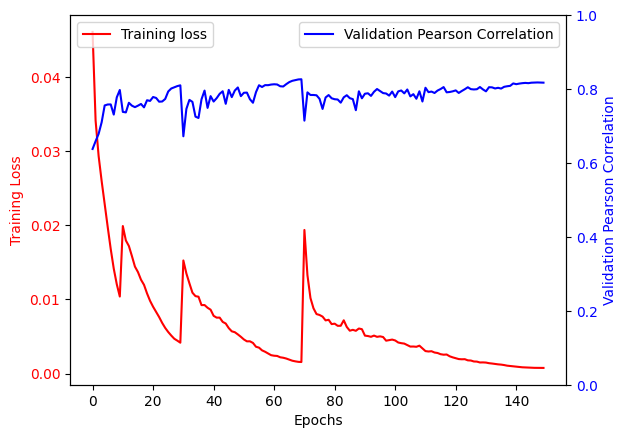

In [ ]:
import time
from torchsummary import summary
import os
import random
timestamp = time.strftime('%Y%m%d_%H%M%S')
save_dir = f'D:/01IscBML/logfile/{timestamp}/'
os.mkdir(save_dir)
torch.manual_seed(42)
sequence_length = FeatureProcessor(file_path='D:/01IscBML/',file_name='A_to_G_S18_Train_del1700_90%.xlsx').sequence_length
# Initialize the model, loss function, and optimizer
model = LocalCNN(sequence_length=sequence_length)


# criterion = BCEFocalLoss()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=0.00001)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Training and validation setup
num_epochs = 150  # Adjust as needed

# Function to calculate Pearson correlation coefficient
def pearson_correlation(predicted, actual):
    pred_mean = predicted.mean()
    actual_mean = actual.mean()
    covariance = ((predicted - pred_mean) * (actual - actual_mean)).sum()
    pred_std = ((predicted - pred_mean) ** 2).sum().sqrt()
    actual_std = ((actual - actual_mean) ** 2).sum().sqrt()
    return (covariance / (pred_std * actual_std)).item()

plot_loss = []
plot_pearson = []
max_r = 0.0
for epoch in range(num_epochs):
    # if epoch == 0:  # Save the architecture only in the first epoch
    #     # for MLP
    #     input_size = sequence_length * channel
    #     model_architecture = summary(model,input_size=(sequence_length,channel))
    model.train()  # Set model to training mode
    running_loss = 0.0

    train_pearson = 0.0  # To accumulate Pearson correlation coefficient for training
    
    # Training loop
    for batch_features,batch_tam_features, batch_labels in tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        # Move data to appropriate device (e.g., GPU if available)
        batch_features, batch_tam_features, batch_labels = batch_features.to(device), batch_tam_features.to(device), batch_labels.to(device)
        
        # Zero the gradients
        optimizer.zero_grad()
        model.to(device)
        # Forward pass
        outputs = model(batch_features, batch_tam_features)
        loss = criterion(outputs, batch_labels)
        
        # Backward pass
        loss.backward(retain_graph=True)
        optimizer.step()
        
        running_loss += loss.item()
        
        # Calculate Pearson correlation for the batch
        predicted = outputs.squeeze(1)  # Remove singleton dimension
        actual = batch_labels.squeeze(1)
        train_pearson += pearson_correlation(predicted, actual)

    # Compute average training loss and Pearson correlation for the epoch
    epoch_loss = running_loss / len(train_dataloader)
    plot_loss.append(epoch_loss)
    epoch_train_pearson = train_pearson / len(train_dataloader)

    # Validation phase
    model.eval()  # Set model to evaluation mode
    val_pearson = 0.0
    with torch.no_grad():
        for val_features, val_tam_features, val_labels in val_dataloader:  # Use a separate validation DataLoader
            val_features, val_tam_features,  val_labels = val_features.to(device),val_tam_features.to(device), val_labels.to(device)
            
            val_outputs = model(val_features,val_tam_features)
            predicted = val_outputs.squeeze(1)
            # print(predicted)
            actual = val_labels.squeeze(1)
            # print(actual)

            # Calculate Pearson correlation for the validation set
            val_pearson += pearson_correlation(predicted, actual)
    
    # Compute average validation Pearson correlation for the epoch
    epoch_val_pearson = val_pearson / len(val_dataloader)
    plot_pearson.append(epoch_val_pearson)

    ##save the model and architecture
    if epoch_val_pearson > max_r:
        max_r = epoch_val_pearson
        model_name = model.__class__.__name__
        save_model_path = f'{save_dir}{model_name}.pth'
        # model_architecture = summary(model, input_size=(sequence_length,channel))
        torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    # 'optimizer_state_dict': optimizer.state_dict(),
                    'loss': loss,
                    # 'architecture': model_architecture,
                    # 'lr': optimizer.param_groups[0]['lr'],
                    }, save_model_path)
    scheduler.step()
    # lr = scheduler.get_last_lr()[0]
    print(f"Model saved with Pearson correlation: {max_r:.4f}")

    # Print training and validation metrics
    print(f"Epoch [{epoch + 1}/{num_epochs}]")
    print(f"Training Loss: {epoch_loss:.4f}")
    print(f"Validation Pearson Correlation: {epoch_val_pearson:.4f}")
    # print(f"lr:{lr:.4f}")

plt.figure()
# plt.switch_backend('agg')
fig, ax1 = plt.subplots()

# model.predict()

ax1.set_xlabel('Epochs')
ax1.set_ylabel('Training Loss', color='r')
ax1.plot(range(num_epochs), plot_loss, 'r', label='Training loss')
ax1.tick_params(axis='y', labelcolor='r')

ax2 = ax1.twinx()
ax2.set_ylabel('Validation Pearson Correlation', color='b')
ax2.plot(range(num_epochs), plot_pearson, 'b', label='Validation Pearson Correlation')
ax2.tick_params(axis='y', labelcolor='b')

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
# plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.ylim(0, 1)
plt.legend()
# plt.show()
file_path = os.path.join(save_dir, 'loss_plot_MLP.png')
plt.savefig(file_path)


In [24]:
###---------test the model----------------
import torch
import pandas as pd

model.load_state_dict(torch.load(save_model_path)['model_state_dict'])
model.eval()
# Initialize variables for tracking
test_results = []  # To store results for each test sample
test_pearson = 0.0

with torch.no_grad():  # Disable gradient computation for evaluation
    for test_features, test_Tam_features, test_labels in test_dataloader:  # Use the test DataLoader
        # Move data to the appropriate device (e.g., CPU)
        test_features, test_labels, test_Tam_features = test_features.to(device), test_labels.to(device), test_Tam_features.to(device)
        print(test_features.shape, test_Tam_features.shape)
        # Perform predictions
        test_outputs = model(test_features, test_Tam_features)
        predicted = test_outputs.squeeze(1)  # Detach to numpy for processing
        actual = test_labels.squeeze(1)

        # Store each prediction with its actual label
        for pred, act in zip(predicted, actual):
            test_results.append({'Predicted': pred.item(), 'Actual': act.item()})
        
        # Calculate Pearson correlation for this batch
        test_pearson += pearson_correlation(predicted, actual)

# Compute average test Pearson correlation
avg_test_pearson = test_pearson / len(test_dataloader)
print(f"Average test Pearson Correlation: {avg_test_pearson}")

# Save test results to a DataFrame and export to a CSV file
results_df = pd.DataFrame(test_results)
test_result_path = f'{save_dir}{timestamp}.csv'
test_result_path2 = f'{save_dir}{timestamp}_2.csv'
results_df.to_csv(f'{save_dir}{timestamp}.csv', index=False)
print("test results saved to 'test_results.csv'.")



C:\Users\SHO\AppData\Local\Temp\ipykernel_21212\3952504352.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(save_model_path)['model_state

torch.Size([2864, 56, 6]) torch.Size([2864, 4, 6])
Average test Pearson Correlation: 0.8113413453102112
test results saved to 'test_results.csv'.


In [12]:
## double check to see if the model test the real test dataset

###---------pred the model----------------
import torch
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
sequence_length = FeatureProcessor(file_path='D:/01IscBML/',file_name='A_to_G_S18_Train_del1700_90%.xlsx').sequence_length
# Initialize the model, loss function, and optimizer
model = LocalCNN(sequence_length=sequence_length)


# 加载模型
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
save_model_path = 'D:/01IscBML/logfile/20250316_1930_save_for_predict/LocalCNN.pth'
model.load_state_dict(torch.load(save_model_path)['model_state_dict'])
model = model.to(device)
model.eval()

# 加载数据和提取特征
predict_combined_features = FeatureProcessor(file_path='D:/01IscBML/', file_name='test_del_keep1700.xlsx').combined_features
predict_Tam_features = predict_combined_features[:, 36:40, :].long()

# 创建数据集和数据加载器
pred_dataset = TensorDataset(predict_combined_features, predict_Tam_features)
pred_dataloader = DataLoader(pred_dataset, batch_size=1, shuffle=False, drop_last=False)

# 初始化一个列表来存储预测结果
pred_results = []

# 进行预测
with torch.no_grad():
    for pred_features, pred_Tam_features in pred_dataloader:
        pred_features, pred_Tam_features = pred_features.to(device), pred_Tam_features.to(device)
        pred_outputs = model(pred_features, pred_Tam_features)
        predicted = pred_outputs.squeeze(1).item()
        pred_results.append(predicted)

# 读取原始数据
file_path = 'D:/01IscBML/test_del_keep1700.xlsx'
df = pd.read_excel(file_path)

# 将预测结果写入原始数据的相应列中
df['a_to_g(%)predict'] = pred_results

# 保存修改后的数据到原始文件
df.to_excel(file_path, index=False)
print("预测结果已写入原始文件。")

C:\Users\SHO\AppData\Local\Temp\ipykernel_33716\2864004338.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(save_model_path)['model_stat

预测结果已写入原始文件。


In [30]:
###---------pred the model----------------
import torch
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd

# 加载模型
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.load_state_dict(torch.load(save_model_path)['model_state_dict'])
model = model.to(device)
model.eval()

# 加载数据和提取特征
predict_combined_features = FeatureProcessor(file_path='D:/01IscBML/Prediction/', file_name='TTR_shuffled.xlsx').combined_features
predict_Tam_features = predict_combined_features[:, 36:40, :].long()

# 创建数据集和数据加载器
pred_dataset = TensorDataset(predict_combined_features, predict_Tam_features)
pred_dataloader = DataLoader(pred_dataset, batch_size=1, shuffle=False, drop_last=False)

# 初始化一个列表来存储预测结果
pred_results = []

# 进行预测
with torch.no_grad():
    for pred_features, pred_Tam_features in pred_dataloader:
        pred_features, pred_Tam_features = pred_features.to(device), pred_Tam_features.to(device)
        pred_outputs = model(pred_features, pred_Tam_features)
        predicted = pred_outputs.squeeze(1).item()
        pred_results.append(predicted)

# 读取原始数据
file_path = 'D:/01IscBML/Prediction/TTR_shuffled.xlsx'
df = pd.read_excel(file_path)

# 将预测结果写入原始数据的相应列中
df['a_to_g(%)'] = pred_results

# 保存修改后的数据到原始文件
df.to_excel(file_path, index=False)
print("预测结果已写入原始文件。")

C:\Users\SHO\AppData\Local\Temp\ipykernel_21212\2491088466.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(save_model_path)['model_state

预测结果已写入原始文件。


In [16]:
# class Pred_featureProcessor:
#     def __init__(self, file_path='D:/01IscBML/', file_name='IscB_gRNA spacer sequence.xlsx'):
#         self.category_map = {'A': 0, 'T': 1, 'C': 2, 'G': 3}
#         self.data_path = file_path + file_name
#         self.df, self.index_tensor = self.load_data(self.data_path)  # load the df and index tensor

#     def __len__(self):
#         return len(self.df)

#     def load_data(self, data_path):
#         df = pd.read_excel(data_path)
#         index_tensor = (df['A_position_counted_from_5_end_of_gRNA'] + 20).astype(int) - 1  # Warning: 0-indexed
#         return df, index_tensor

#     def sequence_to_one_hot(self, sequence, categories="ATCG"):
#         category_map = {char: idx for idx, char in enumerate(categories)}
#         one_hot = []
#         for char in sequence:
#             one_hot_char = [0] * len(categories)
#             if char in category_map:
#                 one_hot_char[category_map[char]] = 1
#             one_hot.append(one_hot_char)
#         return one_hot

#     def process_row(self, row):
#         sequence = row['Target_site_sequence']
#         sequence_length = len(sequence)
#         one_hot_features = self.sequence_to_one_hot(sequence)

#         features_tensor = torch.tensor(one_hot_features, dtype=torch.float32)
#         print(features_tensor.shape)

#         # Create index one-hot feature
#         index = int(row['A_position_counted_from_5_end_of_gRNA'] + 20 - 1)  # Adjust to 0-indexed
#         index_one_hot = [0] * sequence_length
#         if 0 <= index < sequence_length:
#             index_one_hot[index] = 1

#         # Create TAM one-hot feature
#         TAM_one_hot = [0] * sequence_length
#         valid_extra_idxs = [i for i in range(36, 40) if 0 <= i < sequence_length]
#         for extra_idx in valid_extra_idxs:
#             TAM_one_hot[extra_idx] = 2 if extra_idx in range(36, 38) else 3

#         # Combine features
#         index_one_hot_tensor = torch.tensor(index_one_hot, dtype=torch.float32).unsqueeze(1)
#         print(index_one_hot_tensor.shape)
#         TAM_one_hot_tensor = torch.tensor(TAM_one_hot, dtype=torch.float32).unsqueeze(1)
#         print(TAM_one_hot_tensor.shape)
        
#         combined_features = torch.cat((features_tensor, index_one_hot_tensor, TAM_one_hot_tensor), dim=1)
#         print(combined_features.shape)

#         return combined_features, TAM_one_hot_tensor, sequence_length

In [17]:
# ###---------Predict module----------------
# import torch
# import pandas as pd

# # Load the saved model
# model.load_state_dict(torch.load(save_model_path)['model_state_dict'])
# model.eval()

# # Load the Excel file row by row
# file_path = 'D:/01IscBML/'
# file_name = 'IscB_gRNA spacer sequence.xlsx'
# sheet_name = 'IscB gRNA'
# predict_data = pd.read_excel(file_path+file_name, sheet_name=sheet_name)

# # Initialize variables for storing results
# predict_results = []

# # Iterate through each row in the DataFrame
# with torch.no_grad():
#     feature_processor = Pred_featureProcessor(file_path=file_path, file_name=file_name)
#     for index, row in predict_data.iterrows():
#         # Extract features for the current row
#         predict_combined_features,TAM_one_hot_tensor,sequence_length = feature_processor.process_row(row)
#         predict_Tam_features = predict_combined_features[36:40,:].long()

#         # Perform prediction
#         predict_combined_features = predict_combined_features.to(device)
#         TAM_one_hot_tensor = TAM_one_hot_tensor.to(device)
#         predict_output = model(predict_combined_features, TAM_one_hot_tensor)
#         predicted_value = predict_output.squeeze(1).item()

#         # Append prediction to the results
#         predict_results.append(predicted_value)

# # Update the original DataFrame with predictions
# predict_data['a-to-g%'] = predict_results

# # Save the updated DataFrame with predictions
# output_path = f'{save_dir}{timestamp}_predictions.xlsx'
# predict_data.to_excel(output_path, index=False)

# print(f"Predictions saved to '{output_path}'.")


In [18]:
from scipy.stats import pearsonr
from scipy.stats import spearmanr
#output higher efficiency's test correlation

#open the test result file
test_result_2 = pd.read_csv(test_result_path)
#filter all the actural value > 0.2
test_result_2 = test_result_2[test_result_2['Actual'] > 0.2]
test_result_2.to_csv(test_result_path2)

test_values = test_result_2['Predicted']
actual_values = test_result_2['Actual']

# Calculate Pearson correlation
pearson_corr_2 = pearsonr(test_values, actual_values)
spearmanr_2 = spearmanr(test_values, actual_values)[0]
pearson_correlation_2 = pearson_corr_2[0]
print(pearson_correlation_2, spearmanr_2)


0.6843791546467142 0.672136239539635


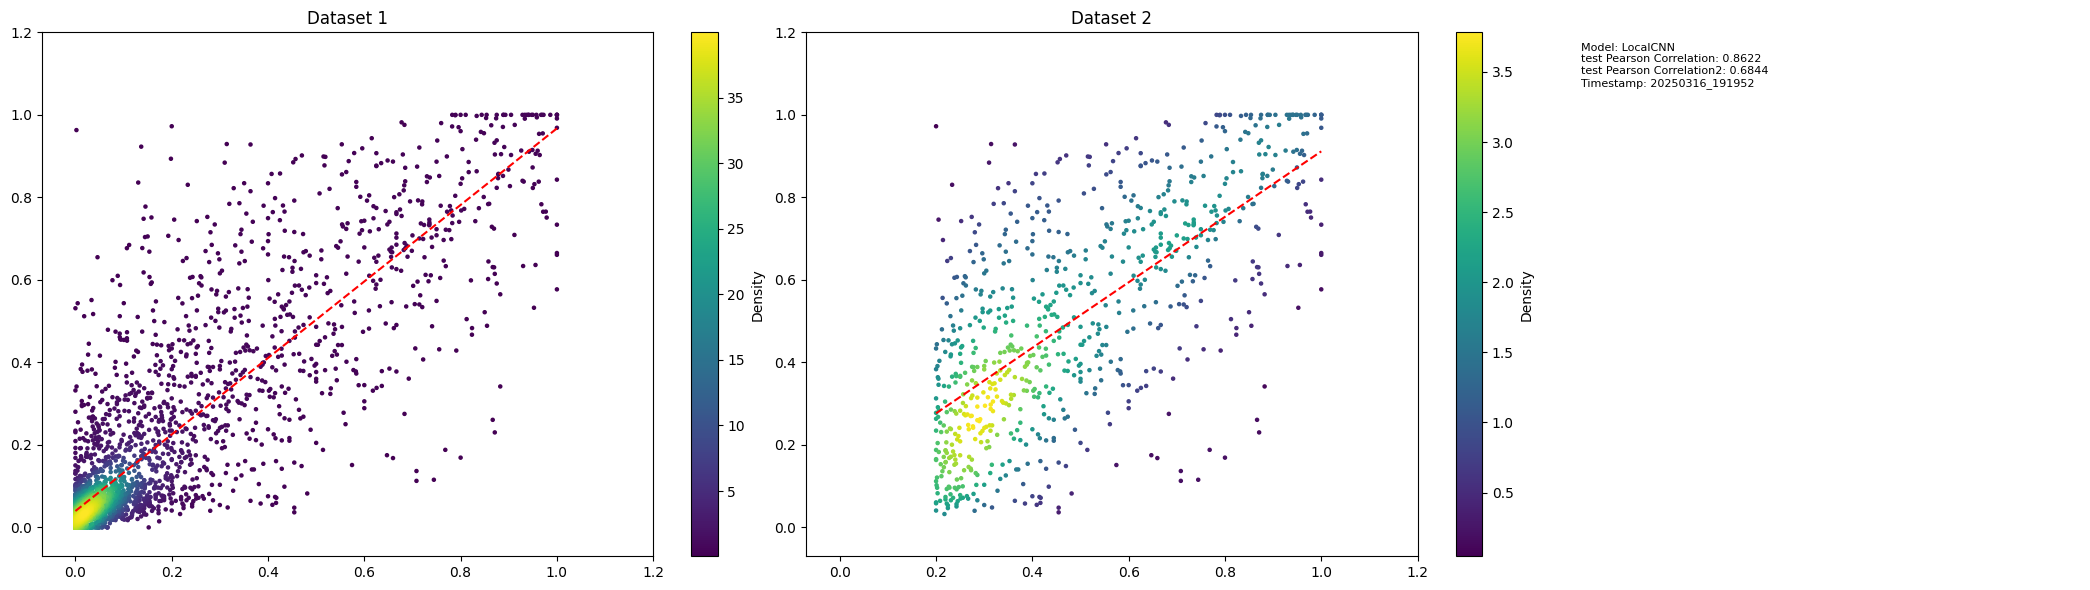

In [19]:
import os
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import matplotlib.gridspec as gridspec
import io
import contextlib

# Load first dataset
test_results_1 = pd.read_csv(test_result_path)
actual_1 = test_results_1['Actual'].values
predicted_1 = test_results_1['Predicted'].values

# Calculate density for first dataset
xy_1 = np.vstack([actual_1, predicted_1])
density_1 = gaussian_kde(xy_1)(xy_1)
sorted_indices_1 = density_1.argsort()
actual_sorted_1 = actual_1[sorted_indices_1]
predicted_sorted_1 = predicted_1[sorted_indices_1]
density_sorted_1 = density_1[sorted_indices_1]

# Load second dataset
test_results_2 = pd.read_csv(test_result_path2)
actual_2 = test_results_2['Actual'].values
predicted_2 = test_results_2['Predicted'].values

# Calculate density for second dataset
xy_2 = np.vstack([actual_2, predicted_2])
density_2 = gaussian_kde(xy_2)(xy_2)
sorted_indices_2 = density_2.argsort()
actual_sorted_2 = actual_2[sorted_indices_2]
predicted_sorted_2 = predicted_2[sorted_indices_2]
density_sorted_2 = density_2[sorted_indices_2]

# Create the plot
plt.figure(figsize=(21, 6))
gs = gridspec.GridSpec(1, 3, width_ratios=[1.5, 1.5,1])

# Plot first dataset
scatter_1 = plt.subplot(gs[0, 0])
scatter_1 = plt.scatter(
    actual_sorted_1,
    predicted_sorted_1,
    c=density_sorted_1,
    cmap='viridis',
    s=5,
    label='Data Points'
)
plt.colorbar(scatter_1, label='Density')
plt.plot(
    np.unique(actual_1),
    np.poly1d(np.polyfit(actual_1, predicted_1, 1))(np.unique(actual_1)),
    color='red',
    linestyle='--',
    label='Regression Line'
)
plt.title('Dataset 1')
plt.xlim(-0.07, 1.2)
plt.ylim(-0.07, 1.2)

# Plot second dataset
scatter_2 = plt.subplot(gs[0, 1])
scatter_2 = plt.scatter(
    actual_sorted_2,
    predicted_sorted_2,
    c=density_sorted_2,
    cmap='viridis',
    s=5,
    label='Data Points'
)
plt.colorbar(scatter_2, label='Density')
plt.plot(
    np.unique(actual_2),
    np.poly1d(np.polyfit(actual_2, predicted_2, 1))(np.unique(actual_2)),
    color='red',
    linestyle='--',
    label='Regression Line'
)
plt.title('Dataset 2')
plt.xlim(-0.07, 1.2)
plt.ylim(-0.07, 1.2)

# Add the model architecture
ax_text = plt.subplot(gs[0,2])  # Use the second section of the grid
ax_text.axis('off')  # Turn off the axes for the text area
info_text = f"Model: {model.__class__.__name__}\n" \
            f"test Pearson Correlation: {avg_test_pearson:.4f}\n" \
            f"test Pearson Correlation2: {pearson_correlation_2:.4f}\n" \
            f"Timestamp: {timestamp}"

plt.tight_layout()
plt.subplots_adjust(wspace=0)
plt.text(0.02, 0.98, info_text, transform=plt.gca().transAxes, fontsize=8, verticalalignment='top')

save_path = os.path.join(save_dir, f"{timestamp}_{avg_test_pearson:.4f}.png")
plt.savefig(save_dir+f'{timestamp}_{avg_test_pearson:.4f}.png')
